Sys.path last entries: ['C:\\Users\\anask\\miniconda3\\envs\\crop_tf\\Lib\\site-packages\\setuptools\\_vendor', 'C:\\Users\\anask\\crop-disease-detection', 'C:\\Users\\anask\\crop-disease-detection\\src']
TensorFlow version: 2.18.1
GPU Available: False

🔄 Creating data generators (batch_size=32)...
Found 49327 images belonging to 38 classes.
Found 15062 images belonging to 38 classes.
Found 15077 images belonging to 38 classes.
✅ Train samples: 49327
✅ Val samples: 15062
✅ Test samples: 15077
✅ Number of classes: 38

✅ Data loaded:
   Train: 49327 images
   Val: 15062 images
   Test: 15077 images
   Classes: 38

Testing custom_cnn

✅ Built model: custom_cnn
   Total params: 1,450,822
   Trainable params: 1,447,878

✅ Model compiled with learning_rate=0.001
Epoch 1/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 1186s 23s/step - accuracy: 0.1737 - loss: 4.5322 - precision: 0.3080 - recall: 0.0988 - top_3_accuracy: 0.3250 - val_accuracy: 0.0000e+00 - val_loss: 5.1831 - val_precision: 0.0000e+00 - val_recal

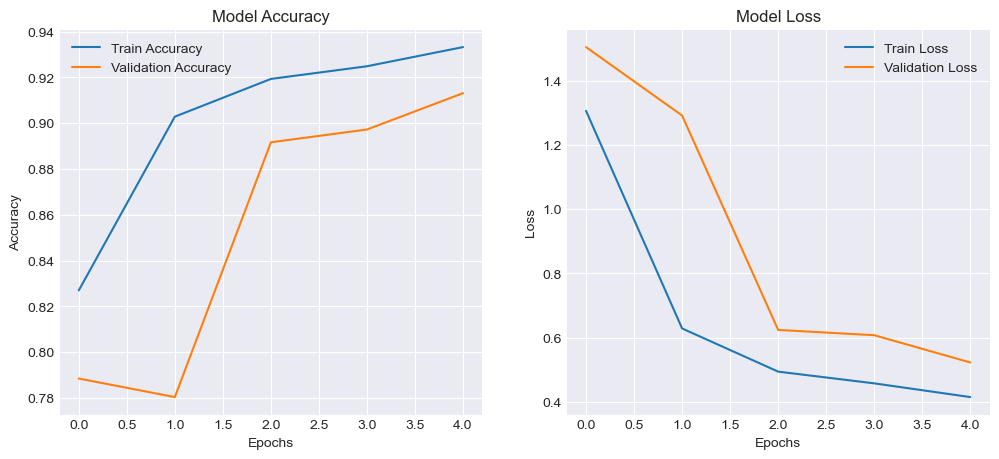

✅ Training curve saved at C:\Users\anask\crop-disease-detection\models\training_curve.png
472/472 ━━━━━━━━━━━━━━━━━━━━ 840s 2s/step - accuracy: 0.9111 - loss: 0.5371 - precision: 0.9167 - recall: 0.9076 - top_3_accuracy: 0.9905


Test Accuracy: 0.9111, Loss: 0.5371
✅ Model saved at C:\Users\anask\crop-disease-detection\models\final_mobilenetv2.h5


In [1]:
# %% [markdown]
# # 03 - Model Training & Experimentation
# This notebook tests different model architectures and hyperparameters

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Ensure project root (crop-disease-detection) is in sys.path
project_root = Path(os.getcwd()).resolve().parent  # one level up from 'notebooks'
sys.path.append(str(project_root))
sys.path.append(str(project_root / "src"))

print("Sys.path last entries:", sys.path[-3:])

from model import ModelBuilder
from data_loader import PlantVillageDataLoader

plt.style.use('seaborn-v0_8-darkgrid')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

# %% [markdown]
# ## 1. Load Data

# %%
# Paths
# Paths
RAW_DATA_PATH = project_root / "src/data/raw/plantvillage-dataset/plantvillage dataset/color"
PROCESSED_DATA_PATH = project_root / "src/data/processed"

# Ensure processed directories exist
for subdir in ["train", "val", "test"]:
    (PROCESSED_DATA_PATH / subdir).mkdir(parents=True, exist_ok=True)

loader = PlantVillageDataLoader(
    raw_data_path=str(RAW_DATA_PATH),
    processed_data_path=str(PROCESSED_DATA_PATH),
    img_size=(224, 224),
    seed=42
)

# Create data generators
train_gen, val_gen, test_gen = loader.create_data_generators(
    batch_size=32,
    augment_train=True
)

# Load class names
class_file = PROCESSED_DATA_PATH / 'class_names.json'
if class_file.exists():
    with open(class_file, 'r') as f:
        class_names = json.load(f)
else:
    raise FileNotFoundError(f"{class_file} not found. Make sure dataset is processed correctly.")

print(f"\n✅ Data loaded:")
print(f"   Train: {train_gen.samples} images")
print(f"   Val: {val_gen.samples} images")
print(f"   Test: {test_gen.samples} images")
print(f"   Classes: {len(class_names)}")


# %% [markdown]
# ## 2. Quick Model Comparison

# %%
def quick_train_test(model_name, epochs=3):
    print(f"\n{'='*70}\nTesting {model_name}\n{'='*70}")

    model = ModelBuilder.build(
        model_name=model_name,
        input_shape=(224, 224, 3),
        num_classes=len(class_names)
    )
    ModelBuilder.compile_model(model, learning_rate=0.001)

    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        steps_per_epoch=min(50, train_gen.samples // train_gen.batch_size),
        validation_steps=min(20, val_gen.samples // val_gen.batch_size),
        verbose=1
    )

    val_loss, val_acc, val_top3, val_precision, val_recall = model.evaluate(
        val_gen, steps=min(20, val_gen.samples // val_gen.batch_size), verbose=0
    )

    return {
        'model': model_name,
        'params': model.count_params(),
        'val_acc': val_acc,
        'val_loss': val_loss
    }

models_to_test = ['custom_cnn', 'mobilenet_v2']
results = []

for m in models_to_test:
    try:
        results.append(quick_train_test(m))
    except Exception as e:
        print(f"Error in {m}: {e}")

df = pd.DataFrame(results)
print(df)

# %% [markdown]
# ## 3. Final Training

# %%
BEST_CONFIG = {
    'model': 'mobilenet_v2',
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 5,
}

final_model = ModelBuilder.build(
    model_name=BEST_CONFIG['model'],
    input_shape=(224, 224, 3),
    num_classes=len(class_names),
    trainable_layers=20,
    dropout_rate=0.5
)
ModelBuilder.compile_model(final_model, learning_rate=BEST_CONFIG['learning_rate'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

print("\n🚀 Starting final training...")
history = final_model.fit(
    train_gen,
    epochs=BEST_CONFIG['epochs'],
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)



# %%
# Plot Training
plt.figure(figsize=(12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save plot image
plot_path = project_root / "models" / "training_curve.png"
plt.savefig(plot_path)
plt.show()

print(f"✅ Training curve saved at {plot_path}")
# %% [markdown]
# ## 4. Evaluate on Test Set

# %%
test_loss, test_acc, test_top3, test_precision, test_recall = final_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

# %% [markdown]
# ## 5. Save Model

# %%
models_dir = project_root / 'models'
models_dir.mkdir(exist_ok=True)
final_model.save(models_dir / 'final_mobilenetv2.h5')
print(f"✅ Model saved at {models_dir / 'final_mobilenetv2.h5'}")
